# Implied Volatility: Newton-Raphson 

In this notebook, we show how to compute implied volatility for European options and plot the volatility smile.

## Data

We are going to use the Yahoo Finance API to get prices for options on Apple (ticker: AAPL) expiring on 16/09/2022 with strike price between 117.5 and 195. For reproducibility, the options data are also available in the files ```aapl_call_data.csv``` and ```aapl_put_data.csv```. We also need an estimate of the risk-free rate and the dividend yield of AAPL. For the risk-free rate, we use the 13 weeks treasury bill rate (^IRX) as a proxy. For the dividend yield proxy, we sum the for most recent quarterly dividends and divide the result by the current stock price.

Let's import the libraries and retrieve all the necessary data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf
import pandas as pd
from datetime import datetime

# Get apple last stock price
aapl = yf.Ticker("AAPL")
div = aapl.get_dividends()[-4:]
S = aapl.history(period='1d')['Close'][0]

# Compute continuously compounded dividend yield
div_yield_cont = np.log(1 + np.sum(div)/S)

# Get proxy for continuously compounded risk-free interest rate
rfr = yf.Ticker("^IRX").history(period='1d')['Close'][0]
rfr = rfr/100
rfr_cont = np.log(1 + rfr)

# Get option infos for the tenth next expiration date
options_expiration = aapl.options[13]
call_info = pd.DataFrame(aapl.option_chain(options_expiration)[0])
put_info = pd.DataFrame(aapl.option_chain(options_expiration)[1])

# Get strikes and corresponding market prices
K = np.array(call_info['strike'])
call_market_price = np.array(call_info['lastPrice'])
put_market_price = np.array(put_info['lastPrice'])

# Calculate time to maturity (as percentage of year)
today = datetime.today().strftime('%Y-%m-%d')
today = datetime.strptime(today, '%Y-%m-%d')
expiration = datetime.strptime(options_expiration, '%Y-%m-%d')
days_to_maturity = (expiration - today).days
T = days_to_maturity/365

# Get range of strikes and market prices
K = K[40:58]
call_market_price = call_market_price[40:58]
put_market_price = put_market_price[40:58]

## Newton-Raphson method

Let $V_{m}$ denote the market price of an option and $V_{b}(\sigma)$ be the price of the option obtained from the Black-Scholes model when the volatility is $\sigma$. Our goal is to find the volatility value $\sigma_I$ such that 

\begin{equation}
    V_{m} = V_{b}(\sigma_I).
\end{equation}

To do so, we use the Newton-Raphson iterative technique. First, we start with an initial guess for the implied volatility, $\sigma_I^{(0)}$. Then, at each step, we update the estimate according to 

\begin{equation}
    \sigma_I^{(n + 1)} = \sigma_I^{(n)} + \frac{V_m - V_b \left(\sigma_I^{(n)} \right)}{\nu \left(\sigma_I^{(n)} \right)}
\end{equation}

where

\begin{equation}
    \nu = \frac{\partial V_b}{\partial \sigma} = S_t \sqrt{T-t} e^{-q(T-t)} \frac{1}{\sqrt{2 \pi}} \exp \left[ -\frac{1}{2}  \left( \frac{\log \frac{S_t}{K} + (r - q + \frac{\sigma^2}{2})(T-t)}{\sigma \sqrt{T - t}} \right)^2 \right]
\end{equation}

is the vega of the option. $S_t$ is the stock price at time $t$, $T$ is the maturity time, $K$ is the strike price $r$ is the risk-free rate and $q$ is the dividend rate.

Let's implement a function that computes the implied volatility.

In [2]:
# Black-Scholes formula
def black_scholes(S, K, T, r, q, sigma, call_put=1):
    """ set call_put = 1 for call and 0 for put """
    d1 = (np.log(S/K) + (r-q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if call_put == 1:
        V = S * np.exp(-q*T) * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    else:
        V = K * np.exp(-r*T) * norm.cdf(-d2) - S * np.exp(-q*T) * norm.cdf(-d1)
    
    # Changes nan values to 0
    V = np.nan_to_num(V,nan=0.0)
    
    return V

# Vega    
def vega_bs(S, K, T, r, q, sigma):    
    d1 = (np.log(S/K) + (r-q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S*np.sqrt(T)*np.exp(-q*T)*norm.pdf(d1)
     
# Compute implied volatility using Newton-Raphson method
def implied_vol(target_price, S, K, T, r, q, max_iter, epsilon, initial_guess=0.5, call_put=1):
    sigma = initial_guess
    for i in range(max_iter):
        V = black_scholes(S, K, T, r, q, sigma, call_put)
        vega = vega_bs(S, K, T, r, q, sigma)
        delta_price = target_price - V
        if (np.abs(delta_price) < epsilon).all():
            return sigma

        #sigma = sigma + np.divide(delta_price, (vega/100))
        sigma = sigma + delta_price / vega / 100
    print('Optimisation failed (algorithm has not converged): return sigma from last iteration.')
    return sigma

Let's define some parameters to stop the optimization. The optimization algorithm stops when the maximum number of iterations is reached or when the algorithm has converged based on the tolerance level.

In [3]:
# Optimisation parameters
max_iter = 1000
epsilon = 1e-4

Finally, let's compute the implied volatility for our option chain and plot the volatility smile.

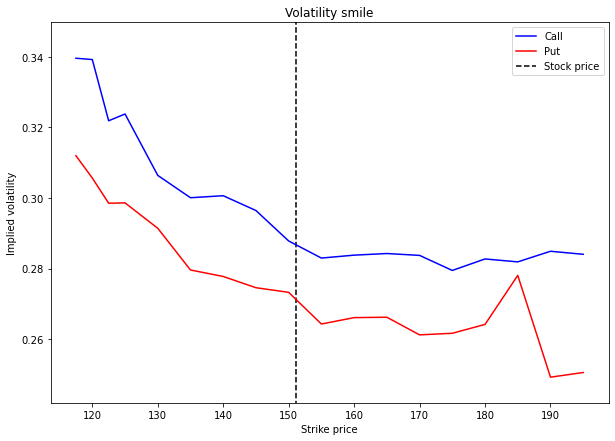

In [4]:
# Compute IV
sigma_call = implied_vol(call_market_price, S, K, T, rfr_cont, div_yield_cont, max_iter, epsilon, 0.3, 1)
sigma_put = implied_vol(put_market_price, S, K, T, rfr_cont, div_yield_cont, max_iter, epsilon, 0.3, 0)

# Plot volatility smile
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(K, sigma_call, 'b', label='Call')
ax.plot(K, sigma_put, 'r', label='Put')
ax.vlines(S, 0, 1, color='k', ls='--', label='Stock price')
ax.set_ylim(np.min((sigma_call.min(), sigma_put.min()))/1.03, np.max((sigma_call.max(), sigma_put.max()))*1.03)
ax.set_xlabel('Strike price')
ax.set_ylabel('Implied volatility')
ax.set_title('Volatility smile')
ax.legend(loc='best');